In [1]:
import itertools
import operator
from pathlib import Path

import numpy as np
from astropy import units as u
from magicctapipe.io import load_mc_dl2_data_file
from matplotlib import gridspec
from matplotlib import pyplot as plt
from pyirf.benchmarks import angular_resolution, energy_bias_resolution
from pyirf.cuts import calculate_percentile_cut, evaluate_binned_cut
from pyirf.irf import effective_area_per_energy

In [2]:
# Configure the pyplot figure
plt.rcParams.update(
    {"figure.figsize": (12, 9), "font.size": 15, "grid.linestyle": "dotted"}
)

# Get the pyplot default color cycle
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Load MAGIC DL2 data

In [3]:
# ================
# === Settings ===
# ================

input_file = (
    "/home/yoshiki.ohtani/lstmagic/mc/zd40deg_az90deg/magic_only_analysis/4.dl1_stereo_to_dl2/"
    "data/gamma/dl2/merged/dl2_magic_only_gamma_zd_40.0deg_az_90.0deg_LST-1_MAGIC_run401_to_1000.h5"
)

quality_cuts = f"(disp_diff_sum < {np.sqrt(0.05)})"

# # ============
# # === Main ===
# # ============

print(f"Input file:\n{Path(input_file).name}" f"\n\nQuality cuts:\n{quality_cuts}")

# Load the input file
data_magic, _, sim_info_magic = load_mc_dl2_data_file(
    input_file, quality_cuts, irf_type="magic_only", dl2_weight_type="simple"
)

# Show the head of the data table
data_magic[:5]

Input file:
dl2_magic_only_gamma_zd_40.0deg_az_90.0deg_LST-1_MAGIC_run401_to_1000.h5

Quality cuts:
(disp_diff_sum < 0.22360679774997896)



In total 477199 stereo events are found:
	m1_m2 (type 0): 477199 events (100.0%)
	lst1_m1 (type 1): 0 events (0.0%)
	lst1_m2 (type 2): 0 events (0.0%)
	lst1_m1_m2 (type 3): 0 events (0.0%)

Extracting the events of the 'magic_only' type...
--> 477199 stereo events


obs_id,event_id,combo_type,multiplicity,true_energy,true_alt,true_az,pointing_alt,pointing_az,reco_energy,reco_alt,reco_az,gammaness,theta,true_source_fov_offset,reco_source_fov_offset
,,,,TeV,deg,deg,rad,rad,TeV,deg,deg,,deg,deg,deg
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
401,13605,0.0,2.0,0.6236247420310974,50.0000002530119,89.999995674289,0.8656833474915151,1.5707963705062864,0.47442311096063333,50.041107128533184,89.94039159450904,0.9444166666666667,0.05618173805480561,0.3999980470153132,0.4427783699442063
401,13606,0.0,2.0,0.6236247420310974,50.0000002530119,89.999995674289,0.8656833474915151,1.5707963705062864,0.4791227937490215,50.04249329803637,89.98580191417803,0.9217142857142857,0.043460612903663334,0.3999980470153132,0.4425859283445896
401,13609,0.0,2.0,0.6236247420310974,50.0000002530119,89.999995674289,0.8656833474915151,1.5707963705062864,0.510110474394079,49.978012862994944,90.00819949231237,0.9770833333333333,0.022611188849645893,0.3999980470153132,0.3780476975549167
401,15600,0.0,2.0,0.21664372086524963,50.0000002530119,89.999995674289,0.8656833474915151,1.5707963705062864,0.22541553850117663,49.753345074962205,89.98526109221594,0.9119166666666667,0.2468378825881244,0.3999980470153132,0.1536392884692065
401,20201,0.0,2.0,0.5037534236907959,50.0000002530119,89.999995674289,0.8656833474915151,1.5707963705062864,0.4853447833440128,50.06186371462703,90.09448415336732,0.9787500000000001,0.08666720138167297,0.3999980470153132,0.4658650375745834


# Load LST-1 + MAGIC DL2 data

In [4]:
# ================
# === Settings ===
# ================

input_file = (
    "/home/yoshiki.ohtani/lstmagic/mc/zd40deg_az90deg/4.dl1_stereo_to_dl2/"
    "data/gamma/dl2/merged/dl2_gamma_zd_40.0deg_az_90.0deg_LST-1_MAGIC_run401_to_1000.h5"
)

quality_cuts = f"(disp_diff_sum < {np.sqrt(0.05) * 3})"

# # ============
# # === Main ===
# # ============

print(f"Input file:\n{Path(input_file).name}" f"\n\nQuality cuts:\n{quality_cuts}")

# Load the input file
data_mlst, _, sim_info_mlst = load_mc_dl2_data_file(
    input_file, quality_cuts, irf_type="software_only_3tel", dl2_weight_type="simple"
)

# Show the head of the data table
data_mlst[:5]

Input file:
dl2_gamma_zd_40.0deg_az_90.0deg_LST-1_MAGIC_run401_to_1000.h5

Quality cuts:
(disp_diff_sum < 0.6708203932499369)



In total 958691 stereo events are found:
	m1_m2 (type 0): 4908 events (0.5%)
	lst1_m1 (type 1): 157259 events (16.4%)
	lst1_m2 (type 2): 295912 events (30.9%)
	lst1_m1_m2 (type 3): 500612 events (52.2%)

Extracting the events of the 'software_only_3tel' type...
--> 500612 stereo events


obs_id,event_id,combo_type,multiplicity,true_energy,true_alt,true_az,pointing_alt,pointing_az,reco_energy,reco_alt,reco_az,gammaness,theta,true_source_fov_offset,reco_source_fov_offset
,,,,TeV,deg,deg,rad,rad,TeV,deg,deg,,deg,deg,deg
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
401,13605,3.0,3.0,0.6236247420310974,50.0000002530119,89.999995674289,0.8656833474915151,1.5707963705062864,0.493167211338147,50.035138353001024,89.97668389117474,0.973,0.03819761682322918,0.3999980470153132,0.4353961808555976
401,13606,3.0,3.0,0.6236247420310974,50.0000002530119,89.999995674289,0.8656833474915151,1.5707963705062864,0.4812703323713227,50.05708333888986,89.9859177589652,0.9438888888888889,0.05779505015573334,0.3999980470153132,0.45717142358350255
401,13609,3.0,3.0,0.6236247420310974,50.0000002530119,89.999995674289,0.8656833474915151,1.5707963705062864,0.5278344248628789,49.950130493480415,90.04751915372616,0.9189166666666666,0.058490260501185554,0.3999980470153132,0.35147036769387685
401,15600,3.0,3.0,0.21664372086524963,50.0000002530119,89.999995674289,0.8656833474915151,1.5707963705062864,0.21163439932421868,49.76818655283729,90.0234989551605,0.9459523809523809,0.23230783664096438,0.3999980470153132,0.16887001422079914
401,15607,3.0,3.0,0.21664372086524963,50.0000002530119,89.999995674289,0.8656833474915151,1.5707963705062864,0.3159329853775016,49.92663671562439,90.07017355478119,0.9821111111111112,0.08614044887733596,0.3999980470153132,0.3297644429127486


# Check the reconstructed energy

Energy bins:
[6.30957344e-02 1.00000000e-01 1.58489319e-01 2.51188643e-01
 3.98107171e-01 6.30957344e-01 1.00000000e+00 1.58489319e+00
 2.51188643e+00 3.98107171e+00 6.30957344e+00 1.00000000e+01
 1.58489319e+01 2.51188643e+01 3.98107171e+01 6.30957344e+01] TeV


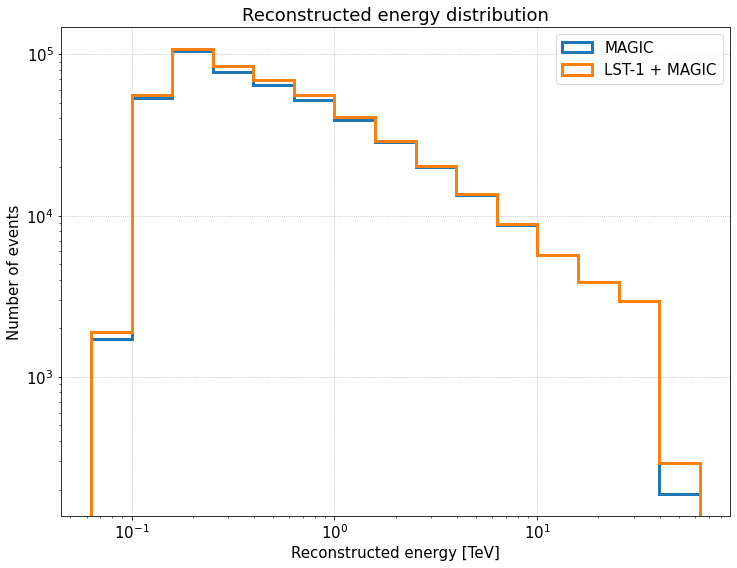

In [5]:
# ================
# === Settings ===
# ================

energy_bins = np.logspace(-2, 2, 21)[4:-1]  # unit: [TeV]
yscale = "log"

# ============
# === Main ===
# ============

print(f"Energy bins:\n{energy_bins} TeV")

energy_bins_center = (energy_bins[:-1] + energy_bins[1:]) / 2

plt.figure()
plt.title("Reconstructed energy distribution")
plt.xlabel("Reconstructed energy [TeV]")
plt.ylabel("Number of events")
plt.semilogx()
plt.yscale(yscale)
plt.grid()

# Plot the MAGIC distribution
plt.hist(
    data_magic["reco_energy"].value,
    bins=energy_bins,
    label="MAGIC",
    histtype="step",
    linewidth=3,
)

# Plot the LST-1 + MAGIC distribution
plt.hist(
    data_mlst["reco_energy"].value,
    bins=energy_bins,
    label="LST-1 + MAGIC",
    histtype="step",
    linewidth=3,
)

plt.legend()

# Check the gammaness

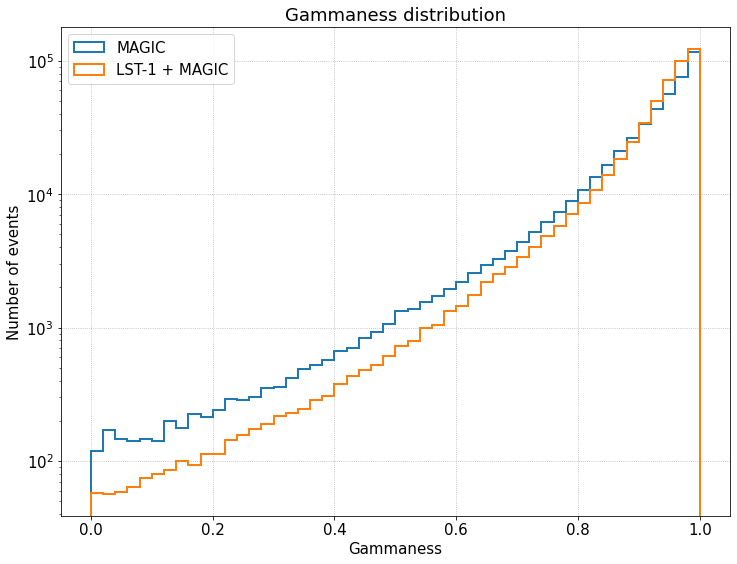

In [6]:
# ================
# === Settings ===
# ================

gh_bins = np.linspace(0, 1, 51)
yscale = "log"

# ============
# === Main ===
# ============

plt.figure()
plt.title("Gammaness distribution")
plt.xlabel("Gammaness")
plt.ylabel("Number of events")
plt.yscale(yscale)
plt.grid()

# Plot the MAGIC distribution
plt.hist(
    data_magic["gammaness"].value,
    bins=gh_bins,
    label="MAGIC",
    histtype="step",
    linewidth=2,
)

# Plot the LST-1 + MAGIC distribution
plt.hist(
    data_mlst["gammaness"].value,
    bins=gh_bins,
    label="LST-1 + MAGIC",
    histtype="step",
    linewidth=2,
)

plt.legend(loc="upper left")

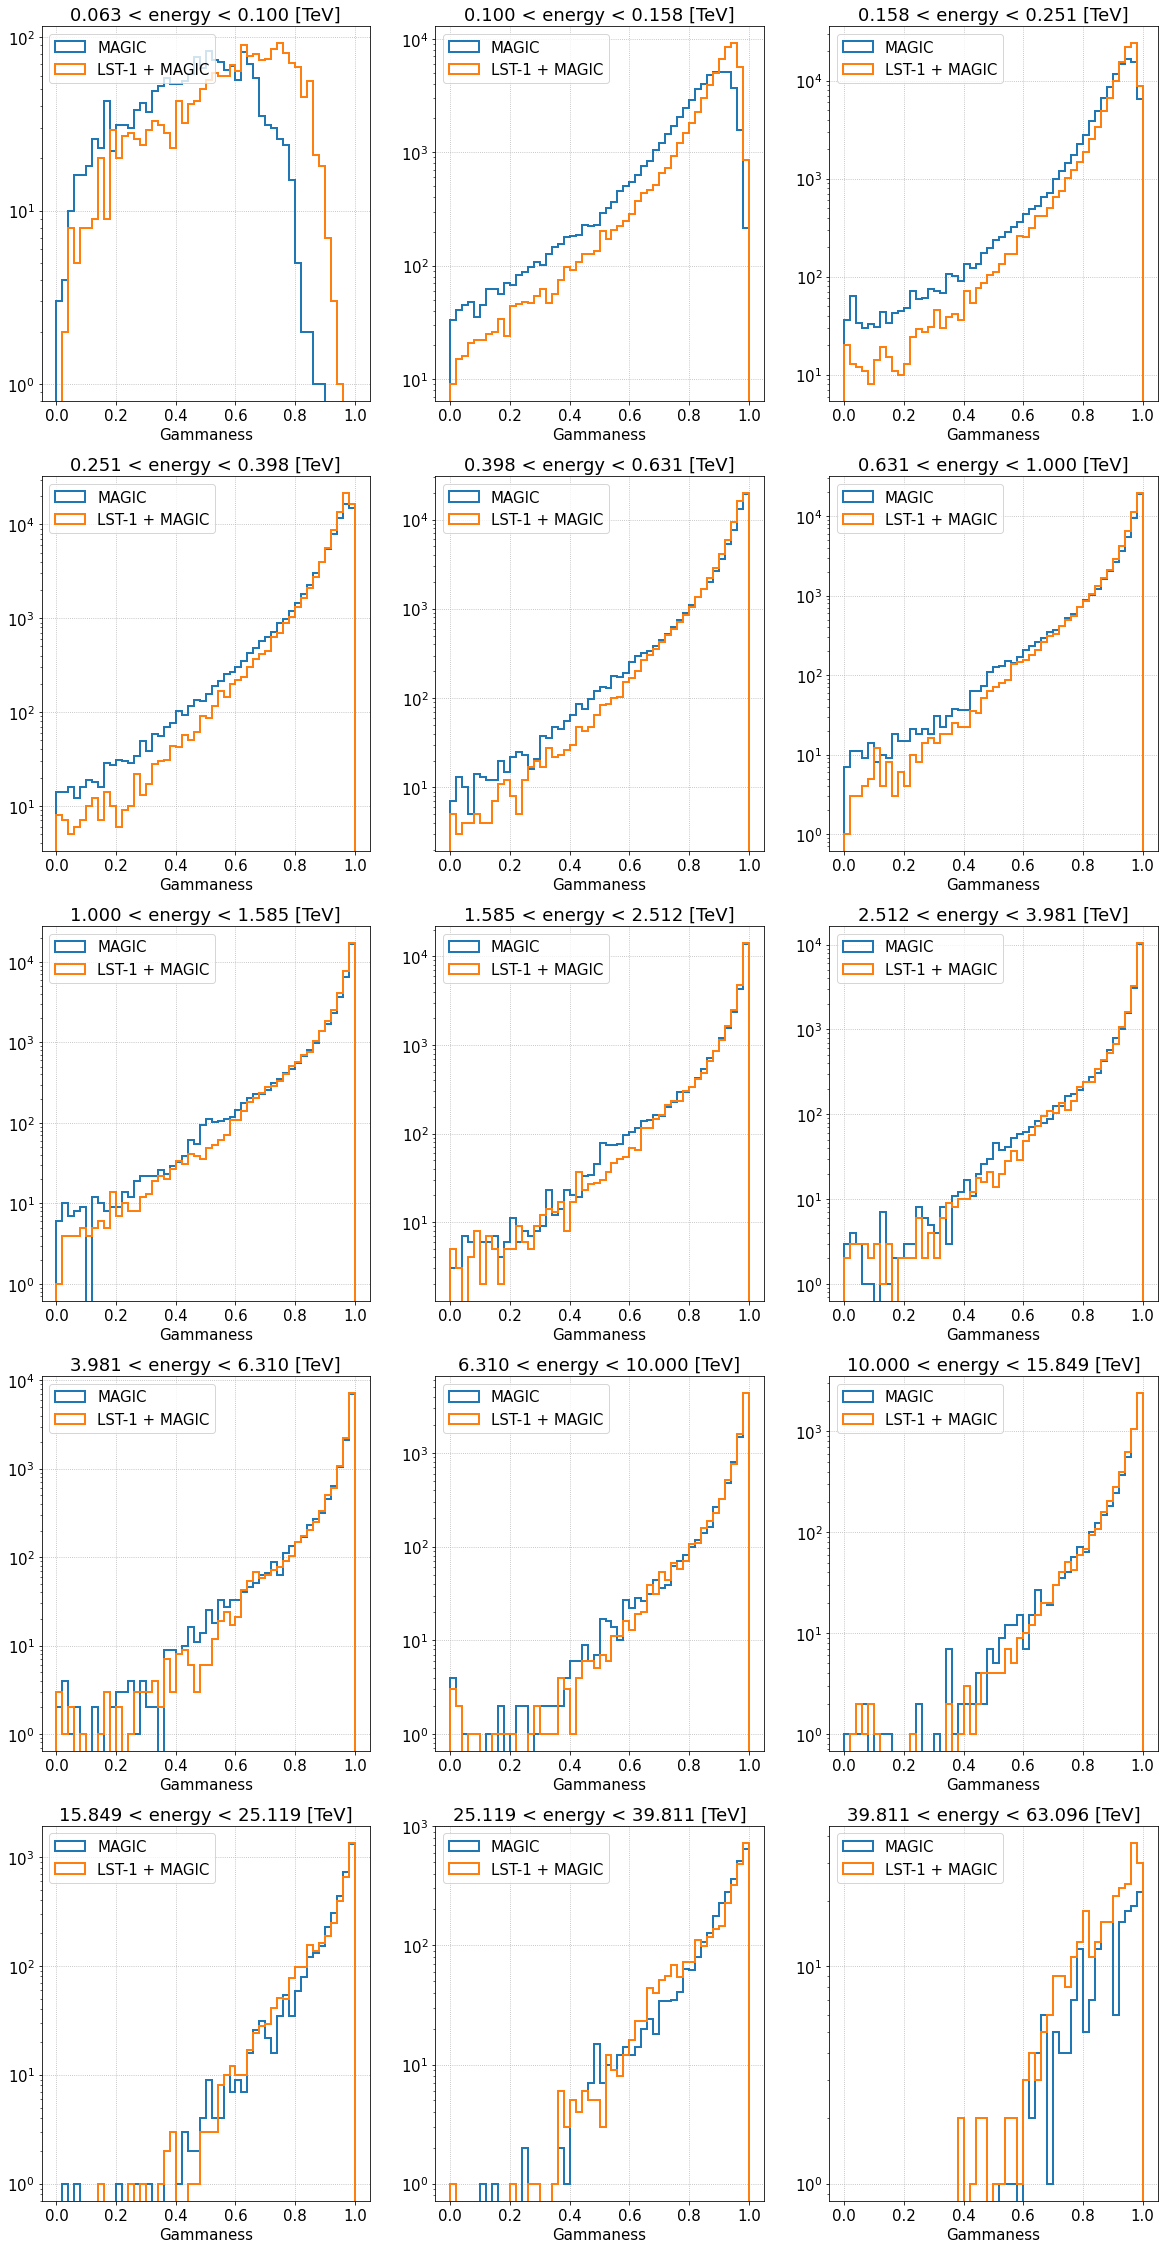

In [7]:
n_columns = 3
n_rows = int(np.ceil(len(energy_bins[:-1]) / n_columns))

grid = (n_rows, n_columns)
locs = list(itertools.product(range(n_rows), range(n_columns)))

plt.figure(figsize=(20, n_rows * 8))

# Loop over every energy bin
for i_bin, (eng_lolim, eng_uplim) in enumerate(zip(energy_bins[:-1], energy_bins[1:])):

    plt.subplot2grid(grid, locs[i_bin])
    plt.title(f"{eng_lolim:.3f} < energy < {eng_uplim:.3f} [TeV]")
    plt.xlabel("Gammaness")
    plt.yscale(yscale)
    plt.grid()

    # Apply the energy cuts
    cond_magic_lolim = data_magic["reco_energy"].value > eng_lolim
    cond_magic_uplim = data_magic["reco_energy"].value < eng_uplim

    cond_mlst_lolim = data_mlst["reco_energy"].value > eng_lolim
    cond_mlst_uplim = data_mlst["reco_energy"].value < eng_uplim

    condition_magic = np.logical_and(cond_magic_lolim, cond_magic_uplim)
    condition_mlst = np.logical_and(cond_mlst_lolim, cond_mlst_uplim)

    dt_magic = data_magic[condition_magic]
    dt_mlst = data_mlst[condition_mlst]

    # Plot the MAGIC distribution
    if len(dt_magic) > 0:
        plt.hist(
            dt_magic["gammaness"].value,
            bins=gh_bins,
            label="MAGIC",
            histtype="step",
            linewidth=2,
        )

    # Plot the LST-1 + MAGIC distribution
    if len(dt_mlst) > 0:
        plt.hist(
            dt_mlst["gammaness"].value,
            bins=gh_bins,
            label="LST-1 + MAGIC",
            histtype="step",
            linewidth=2,
        )

    plt.legend(loc="upper left")

# Apply dynamic gammaness cuts

In [8]:
# ================
# === Settings ===
# ================

gh_efficiency = 0.9

# ============
# === Main ===
# ============

print(f"Efficiency: {gh_efficiency}")

gh_percentile = 100 * (1 - gh_efficiency)

# Calculate the MAGIC dynamic gammaness cuts
gh_table_magic = calculate_percentile_cut(
    values=data_magic["gammaness"],
    bin_values=data_magic["reco_energy"],
    bins=u.Quantity(energy_bins, u.TeV),
    fill_value=0.0,
    percentile=gh_percentile,
)

gh_cuts_magic = gh_table_magic["cut"].value
print(f"\nMAGIC gammaness cuts:\n{gh_cuts_magic}")

# Calculate the LST-1 + MAGIC dynamic gammaness cuts
gh_table_mlst = calculate_percentile_cut(
    values=data_mlst["gammaness"],
    bin_values=data_mlst["reco_energy"],
    bins=u.Quantity(energy_bins, u.TeV),
    fill_value=0.0,
    percentile=gh_percentile,
)

gh_cuts_mlst = gh_table_mlst["cut"].value
print(f"\nLST-1 + MAGIC gammaness cuts:\n{gh_cuts_mlst}")

Efficiency: 0.9

MAGIC gammaness cuts:
[0.19223194 0.62501667 0.76832619 0.78291667 0.79791667 0.7964131
 0.80075417 0.81733333 0.83201012 0.84783333 0.8525     0.83653869
 0.82785119 0.765875   0.69676786]

LST-1 + MAGIC gammaness cuts:
[0.2737119  0.73288889 0.82163175 0.82755556 0.82844444 0.82289524
 0.82400952 0.84039206 0.84983889 0.86278889 0.85960159 0.85062222
 0.79972222 0.72755278 0.6826    ]


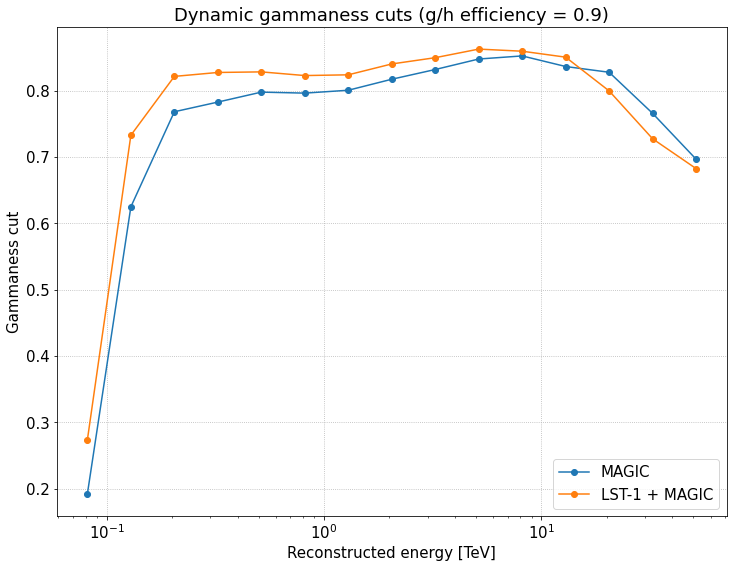

In [9]:
plt.figure()
plt.title(f"Dynamic gammaness cuts (g/h efficiency = {gh_efficiency})")
plt.xlabel("Reconstructed energy [TeV]")
plt.ylabel("Gammaness cut")
plt.semilogx()
plt.grid()

# Plot the MAGIC dynamic gammaness cuts
plt.plot(energy_bins_center, gh_cuts_magic, label="MAGIC", marker="o")

# Plot the LST-1 + MAGIC dynamic gammaness cuts
plt.plot(energy_bins_center, gh_cuts_mlst, label="LST-1 + MAGIC", marker="o")

plt.legend(loc="lower right")

In [10]:
# Apply the MAGIC dynamic gammaness cuts
print("Applying the MAGIC gammaness cuts...")

mask_gh_magic = evaluate_binned_cut(
    values=data_magic["gammaness"],
    bin_values=data_magic["reco_energy"],
    cut_table=gh_table_magic,
    op=operator.ge,
)

data_magic_gcut = data_magic[mask_gh_magic]
print(f"--> Number of events: {len(data_magic_gcut)}")

# Apply the LST-1 + MAGIC dynamic gammaness cuts
print("\nApplying the LST-1 + MAGIC gammaness cuts...")

mask_gh_mlst = evaluate_binned_cut(
    values=data_mlst["gammaness"],
    bin_values=data_mlst["reco_energy"],
    cut_table=gh_table_mlst,
    op=operator.ge,
)

data_mlst_gcut = data_mlst[mask_gh_mlst]
print(f"--> Number of events: {len(data_mlst_gcut)}")

Applying the MAGIC gammaness cuts...
--> Number of events: 429479

Applying the LST-1 + MAGIC gammaness cuts...
--> Number of events: 450546


# Check the reconstructed direction

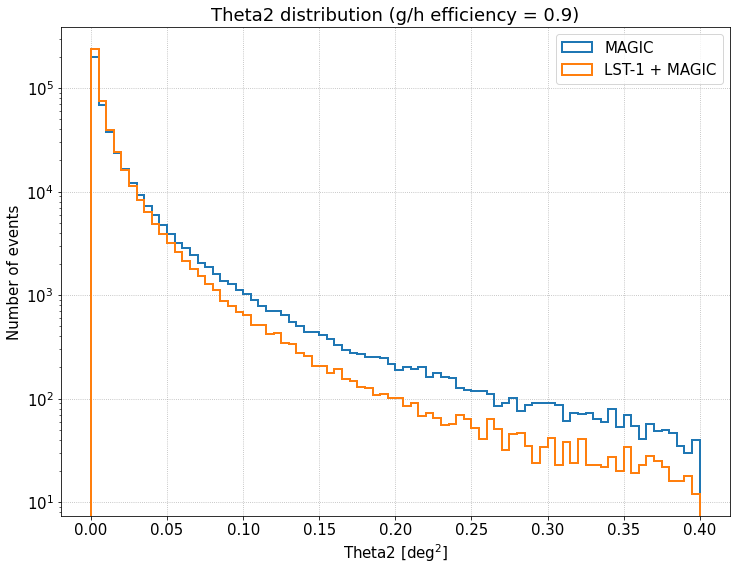

In [11]:
# ================
# === Settings ===
# ================

theta2_bins = np.linspace(0, 0.4, 81)
yscale = "log"

# ============
# === Main ===
# ============

plt.figure()
plt.title(f"Theta2 distribution (g/h efficiency = {gh_efficiency})")
plt.xlabel("Theta2 [deg$^2$]")
plt.ylabel("Number of events")
plt.yscale(yscale)
plt.grid()

# Plot the MAGIC distribution
plt.hist(
    np.square(data_magic_gcut["theta"].value),
    bins=theta2_bins,
    label="MAGIC",
    histtype="step",
    linewidth=2,
)

# Plot the LST-1 + MAGIC distribution
plt.hist(
    np.square(data_mlst_gcut["theta"].value),
    bins=theta2_bins,
    label="LST-1 + MAGIC",
    histtype="step",
    linewidth=2,
)

plt.legend()

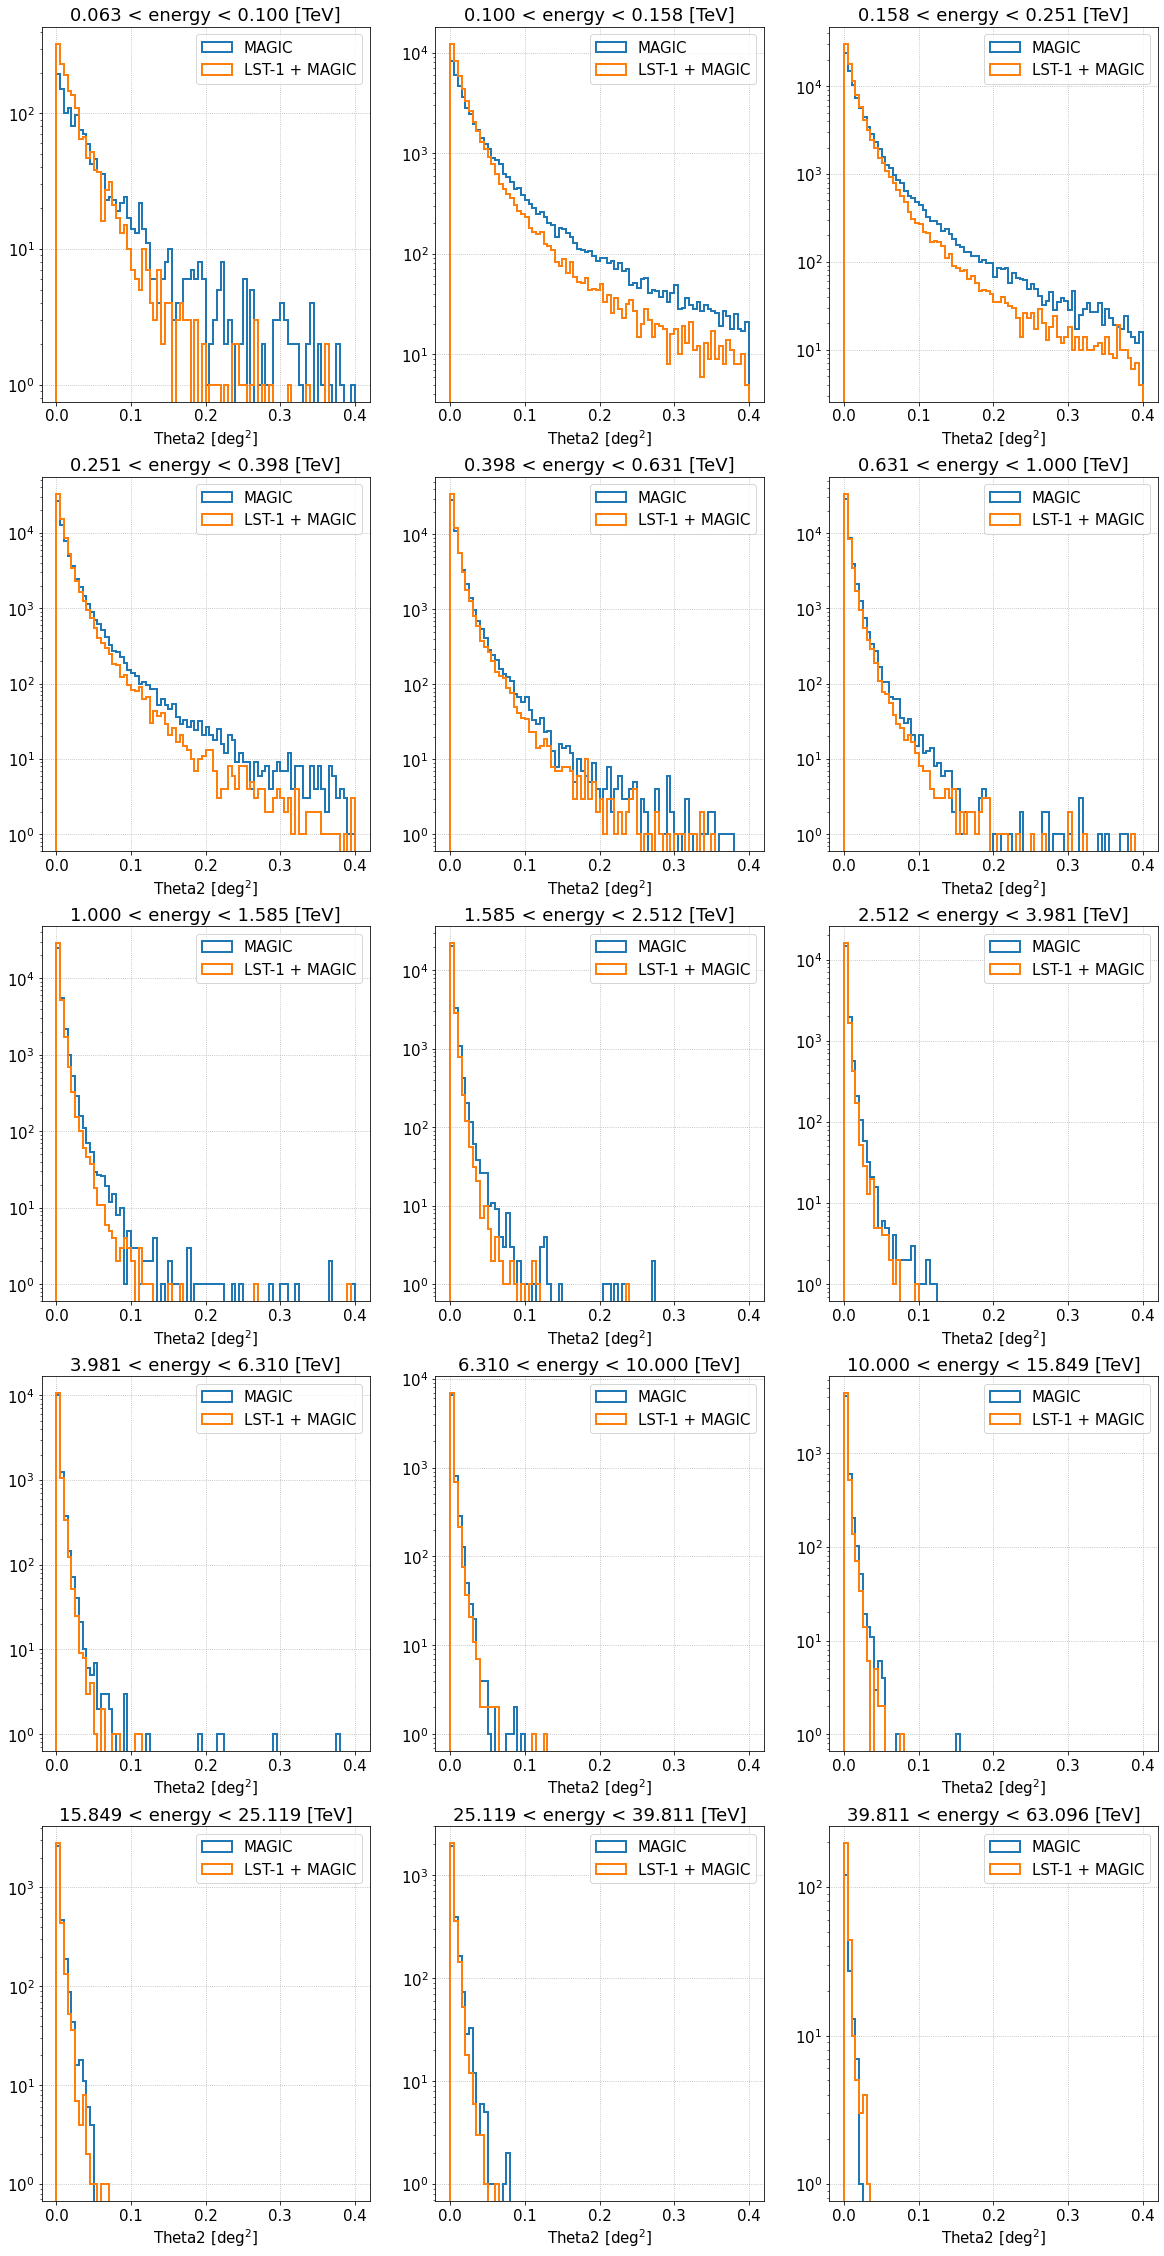

In [12]:
n_columns = 3
n_rows = int(np.ceil(len(energy_bins[:-1]) / n_columns))

grid = (n_rows, n_columns)
locs = list(itertools.product(range(n_rows), range(n_columns)))

plt.figure(figsize=(20, n_rows * 8))

# Loop over every energy bin
for i_bin, (eng_lolim, eng_uplim) in enumerate(zip(energy_bins[:-1], energy_bins[1:])):

    plt.subplot2grid(grid, locs[i_bin])
    plt.title(f"{eng_lolim:.3f} < energy < {eng_uplim:.3f} [TeV]")
    plt.xlabel("Theta2 [deg$^2$]")
    plt.yscale(yscale)
    plt.grid()

    # Apply the energy cuts
    cond_magic_lolim = data_magic_gcut["reco_energy"].value > eng_lolim
    cond_magic_uplim = data_magic_gcut["reco_energy"].value < eng_uplim

    cond_mlst_lolim = data_mlst_gcut["reco_energy"].value > eng_lolim
    cond_mlst_uplim = data_mlst_gcut["reco_energy"].value < eng_uplim

    condition_magic = np.logical_and(cond_magic_lolim, cond_magic_uplim)
    condition_mlst = np.logical_and(cond_mlst_lolim, cond_mlst_uplim)

    dt_magic = data_magic_gcut[condition_magic]
    dt_mlst = data_mlst_gcut[condition_mlst]

    # Plot the MAGIC distribution
    if len(dt_magic) > 0:
        plt.hist(
            np.square(dt_magic["theta"].value),
            bins=theta2_bins,
            label="MAGIC",
            histtype="step",
            linewidth=2,
        )

    # Plot the LST-1 + MAGIC distribution
    if len(dt_mlst) > 0:
        plt.hist(
            np.square(dt_mlst["theta"].value),
            bins=theta2_bins,
            label="LST-1 + MAGIC",
            histtype="step",
            linewidth=2,
        )

    plt.legend(loc="upper right")

# Check the angular resolution

In [13]:
# Calculate the MAGIC angular resolution
angres_table_magic = angular_resolution(
    data_magic_gcut, u.Quantity(energy_bins, u.TeV), energy_type="reco"
)

angres_magic = angres_table_magic["angular_resolution"].value
print(f"MAGIC angular resolution:\n{angres_magic} deg")

# Calculate the LST-1 + MAGIC angular resolution
angres_table_mlst = angular_resolution(
    data_mlst_gcut, u.Quantity(energy_bins, u.TeV), energy_type="reco"
)

angres_mlst = angres_table_mlst["angular_resolution"].value
print(f"\nLST-1 + MAGIC angular resolution:\n{angres_mlst} deg")

# Calculate the relative difference
angres_rel_diff = (angres_mlst - angres_magic) / angres_magic
print(f"\nRelative difference:\n{angres_rel_diff}")

MAGIC angular resolution:
[0.24328077 0.2119327  0.16875328 0.12538155 0.09774207 0.08126975
 0.06680039 0.0578299  0.05255134 0.05131309 0.05155651 0.05414372
 0.06126971 0.06636643 0.06852228] deg

LST-1 + MAGIC angular resolution:
[0.176263   0.16069371 0.13739087 0.10835611 0.08763352 0.07228498
 0.06014794 0.05213072 0.04788981 0.04727488 0.04796794 0.05054129
 0.05699773 0.06101443 0.06382218] deg

Relative difference:
[-0.275475   -0.24177012 -0.18584771 -0.13578899 -0.1034207  -0.11055487
 -0.09958704 -0.09855063 -0.0887043  -0.07869746 -0.06960458 -0.06653458
 -0.06972421 -0.08064311 -0.06859226]


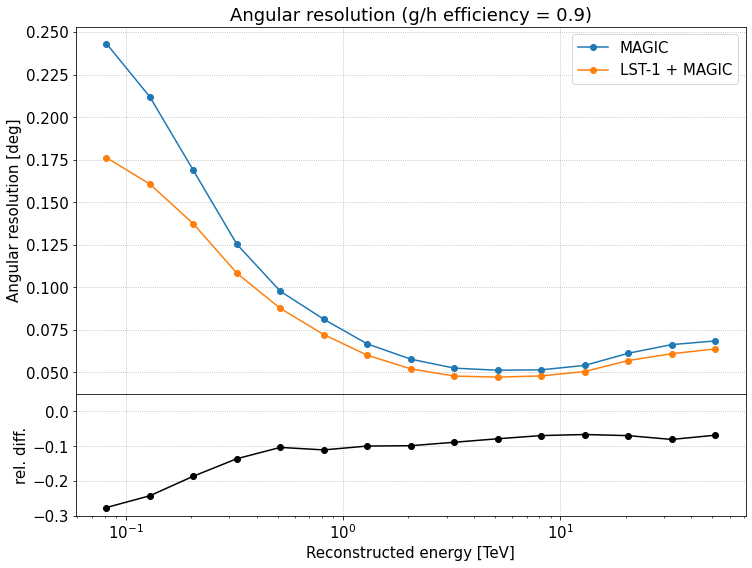

In [14]:
plt.figure()
gs = gridspec.GridSpec(4, 1)

ax1 = plt.subplot(gs[:3])
ax1.set_title(f"Angular resolution (g/h efficiency = {gh_efficiency})")
ax1.set_ylabel("Angular resolution [deg]")
ax1.semilogx()
ax1.grid()

ax2 = plt.subplot(gs[3], sharex=ax1)
ax2.set_xlabel("Reconstructed energy [TeV]")
ax2.set_ylabel("rel. diff.")
ax2.semilogx()
ax2.set_ylim(-0.30, 0.05)
ax2.grid()

plt.setp(ax1.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=0.0)

# Plot the MAGIC angular resolution
ax1.plot(energy_bins_center, angres_magic, label="MAGIC", marker="o")

# Plot the LST-1 + MAGIC angular resolution
ax1.plot(energy_bins_center, angres_mlst, label="LST-1 + MAGIC", marker="o")

# Plot the relative difference
ax2.errorbar(energy_bins_center, angres_rel_diff, marker="o", color="black")

ax1.legend()

# Apply dynamic theta cuts

In [15]:
# ================
# === Settings ===
# ================

theta_efficiency = 0.75

# ============
# === Main ===
# ============

print(f"Efficiency: {theta_efficiency}")

theta_percentile = 100 * theta_efficiency

theta_table_magic = calculate_percentile_cut(
    values=data_magic_gcut["theta"],
    bin_values=data_magic_gcut["reco_energy"],
    bins=u.Quantity(energy_bins, u.TeV),
    fill_value=data_magic_gcut["theta"].max(),
    percentile=theta_percentile,
)

theta_cuts_magic = theta_table_magic["cut"]
print(f"\nMAGIC theta cuts:\n{theta_cuts_magic}")

theta_table_mlst = calculate_percentile_cut(
    values=data_mlst_gcut["theta"],
    bin_values=data_mlst_gcut["reco_energy"],
    bins=u.Quantity(energy_bins, u.TeV),
    fill_value=data_mlst_gcut["theta"].max(),
    percentile=theta_percentile,
)

theta_cuts_mlst = theta_table_mlst["cut"]
print(f"\nLST-1 + MAGIC theta cuts:\n{theta_cuts_mlst}")

Efficiency: 0.75

MAGIC theta cuts:
[0.27909518 0.24426893 0.1942841  0.14368046 0.11136914 0.09255418
 0.07568433 0.06541066 0.05952619 0.05834263 0.05897289 0.0627123
 0.07016219 0.07520395 0.07596091] deg

LST-1 + MAGIC theta cuts:
[0.20022463 0.18186976 0.15567976 0.12251971 0.0993477  0.0821872
 0.06777194 0.0588284  0.05415489 0.05345705 0.05461933 0.0572899
 0.06377235 0.06819226 0.07231284] deg


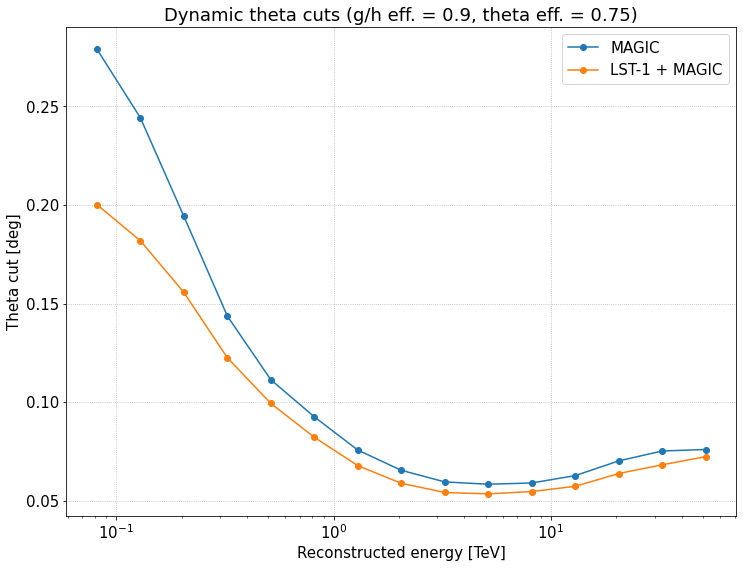

In [16]:
plt.figure()
plt.title(
    "Dynamic theta cuts "
    f"(g/h eff. = {gh_efficiency}, theta eff. = {theta_efficiency})"
)
plt.xlabel("Reconstructed energy [TeV]")
plt.ylabel("Theta cut [deg]")
plt.semilogx()
plt.grid()

# Plot the MAGIC dynamic gammaness cuts
plt.plot(energy_bins_center, theta_cuts_magic, label="MAGIC", marker="o")

# Plot the LST-1 + MAGIC dynamic gammaness cuts
plt.plot(energy_bins_center, theta_cuts_mlst, label="LST-1 + MAGIC", marker="o")

plt.legend(loc="upper right")

In [17]:
# Apply the MAGIC dynamic theta cuts
print("Applying the MAGIC theta cuts...")

mask_theta_magic = evaluate_binned_cut(
    values=data_magic_gcut["theta"],
    bin_values=data_magic_gcut["reco_energy"],
    cut_table=theta_table_magic,
    op=operator.le,
)

data_magic_gtcuts = data_magic_gcut[mask_theta_magic]
print(f"--> Number of events: {len(data_magic_gtcuts)}")

# Apply the LST-1 + MAGIC dynamic theta cuts
print("\nApplying the LST-1 + MAGIC theta cuts...")

mask_theta_mlst = evaluate_binned_cut(
    values=data_mlst_gcut["theta"],
    bin_values=data_mlst_gcut["reco_energy"],
    cut_table=theta_table_mlst,
    op=operator.le,
)

data_mlst_gtcuts = data_mlst_gcut[mask_theta_mlst]
print(f"--> Number of events: {len(data_mlst_gtcuts)}")

Applying the MAGIC theta cuts...
--> Number of events: 322107

Applying the LST-1 + MAGIC theta cuts...
--> Number of events: 337905


# Check the effective area

In [18]:
# Calculate the MAGIC effective area
aeff_magic = effective_area_per_energy(
    selected_events=data_magic_gtcuts,
    simulation_info=sim_info_magic,
    true_energy_bins=u.Quantity(energy_bins, u.TeV),
)

print(f"MAGIC effective area:\n{aeff_magic}")

# Calculate the LST-1 + MAGIC effective area
aeff_mlst = effective_area_per_energy(
    selected_events=data_mlst_gtcuts,
    simulation_info=sim_info_mlst,
    true_energy_bins=u.Quantity(energy_bins, u.TeV),
)

print(f"\nLST-1 + MAGIC effective area:\n{aeff_mlst}")

MAGIC effective area:
[  3251.4142197   19238.23500801  45712.75269612  67875.13209254
  89168.23138952 115462.26254327 138404.56840294 158292.80065963
 174136.16644128 190816.27407668 189606.75192001 199997.15493207
 208671.93705284 219113.43176787 192200.53235518] m2

LST-1 + MAGIC effective area:
[  3122.19547817  20392.96832594  48602.43002458  72189.40885504
  96329.1788301  122052.09612037 143889.6793426  161376.74201018
 176907.15597652 190368.96901225 190670.14804737 201171.80625062
 209562.31382071 222705.45523947 188150.32956608] m2


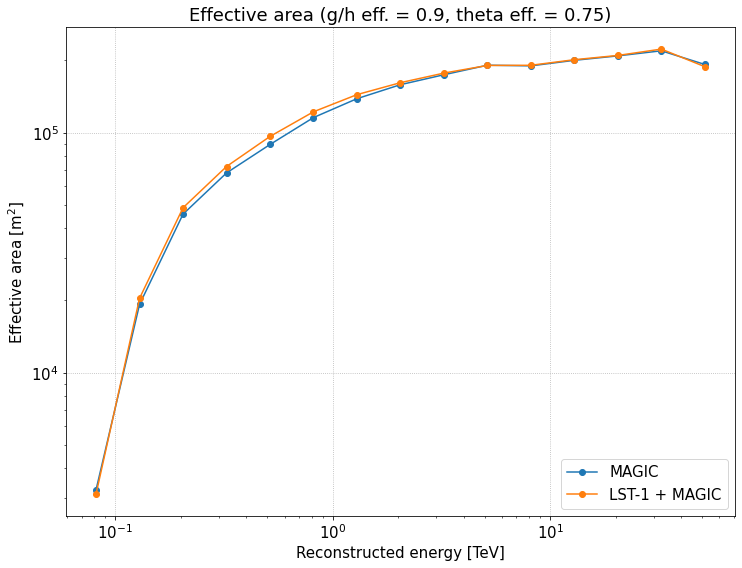

In [19]:
plt.figure()
plt.title(
    "Effective area " f"(g/h eff. = {gh_efficiency}, theta eff. = {theta_efficiency})"
)
plt.xlabel("Reconstructed energy [TeV]")
plt.ylabel("Effective area [m$^2$]")
plt.loglog()
plt.grid()

# Plot the MAGIC effective area
plt.plot(energy_bins_center, aeff_magic.value, label="MAGIC", marker="o")

# Plot the LST-1 + MAGIC effective area
plt.plot(energy_bins_center, aeff_mlst.value, label="LST-1 + MAGIC", marker="o")

plt.legend(loc="lower right")

# Check the energy bias and resolution

In [20]:
# Calculate the MAGIC energy bias and resolution
engres_table_magic = energy_bias_resolution(
    data_magic_gtcuts, u.Quantity(energy_bins, u.TeV), energy_type="reco"
)

engbias_magic = engres_table_magic["bias"].value
engres_magic = engres_table_magic["resolution"].value

print(
    f"MAGIC energy bias:\n{engbias_magic}"
    f"\n\nMAGIC energy resolution:\n{engres_magic}"
)

# Calculate the LST-1 + MAGIC energy bias and resolution
engres_table_mlst = energy_bias_resolution(
    data_mlst_gtcuts, u.Quantity(energy_bins, u.TeV), energy_type="reco"
)

engbias_mlst = engres_table_mlst["bias"].value
engres_mlst = engres_table_mlst["resolution"].value

print(
    f"\nLST-1 + MAGIC energy bias:\n{engbias_mlst}"
    f"\n\nLST-1 + MAGIC energy resolution:\n{engres_mlst}"
)

# Calculate the relative difference of the resolutions
engres_rel_diff = (engres_mlst - engres_magic) / engres_magic
print(f"\nRelative difference of the resolutions:\n{engres_rel_diff}")

MAGIC energy bias:
[ 0.18831436  0.11682577  0.03833635  0.00328948 -0.00788308 -0.00970741
 -0.00893303 -0.01090043 -0.01130354 -0.00760949 -0.00975039 -0.00954214
 -0.00700718 -0.04138319 -0.08736833]

MAGIC energy resolution:
[0.34815029 0.31725587 0.25528724 0.19458932 0.16438495 0.14109922
 0.12499767 0.10913205 0.10678713 0.10169451 0.09982787 0.1068675
 0.12340764 0.12780733 0.06427891]

LST-1 + MAGIC energy bias:
[ 0.23843961  0.13557113  0.03565657  0.0015945  -0.00447058 -0.0056476
 -0.00429971 -0.00681997 -0.00471185 -0.00359882 -0.00478856 -0.00348948
 -0.00487922 -0.02680432 -0.08177456]

LST-1 + MAGIC energy resolution:
[0.28764842 0.25880853 0.19796402 0.15808538 0.13658665 0.11894669
 0.10771339 0.09478809 0.09058139 0.08771847 0.08811487 0.09007258
 0.09964693 0.10963852 0.06287127]

Relative difference of the resolutions:
[-0.17378087 -0.18422775 -0.22454403 -0.18759477 -0.16910488 -0.15699968
 -0.13827682 -0.13143673 -0.15175741 -0.13743159 -0.11733195 -0.15715643
 -

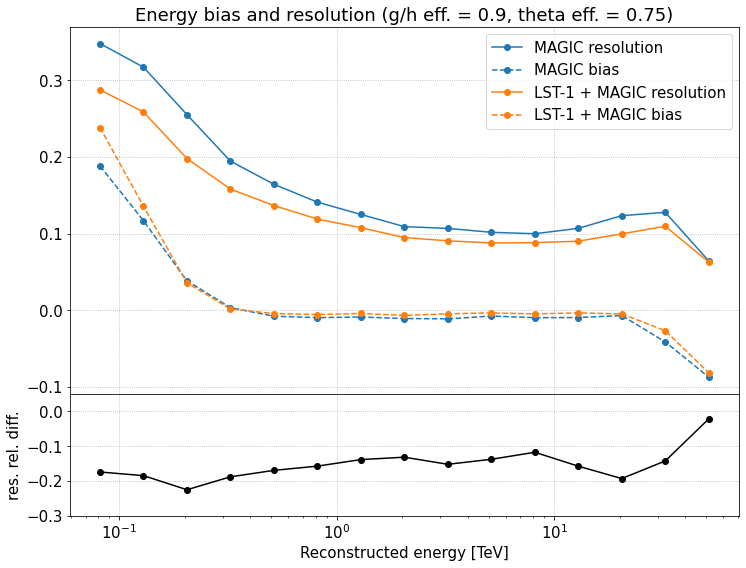

In [21]:
plt.figure()
gs = gridspec.GridSpec(4, 1)

ax1 = plt.subplot(gs[:3])
ax1.set_title(
    "Energy bias and resolution "
    f"(g/h eff. = {gh_efficiency}, theta eff. = {theta_efficiency})"
)
ax1.semilogx()
ax1.grid()

ax2 = plt.subplot(gs[3], sharex=ax1)
ax2.set_xlabel("Reconstructed energy [TeV]")
ax2.set_ylabel("res. rel. diff.")
ax2.semilogx()
ax2.set_ylim(-0.30, 0.05)
ax2.grid()

plt.setp(ax1.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=0.0)

# Plot the MAGIC energy bias and resolution
ax1.plot(
    energy_bins_center,
    engres_magic,
    label="MAGIC resolution",
    marker="o",
    color=colors[0],
)

ax1.plot(
    energy_bins_center,
    engbias_magic,
    label="MAGIC bias",
    marker="o",
    linestyle="--",
    color=colors[0],
)

# Plot the MAGIC energy bias and resolution
ax1.plot(
    energy_bins_center,
    engres_mlst,
    label="LST-1 + MAGIC resolution",
    marker="o",
    color=colors[1],
)

ax1.plot(
    energy_bins_center,
    engbias_mlst,
    label="LST-1 + MAGIC bias",
    marker="o",
    linestyle="--",
    color=colors[1],
)

# Plot the relative difference
ax2.errorbar(energy_bins_center, engres_rel_diff, marker="o", color="black")

ax1.legend()